<a href="https://colab.research.google.com/github/Pakapakk/Network_Traffic_Anomaly_Detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:

kdd_df = pd.read_csv("hf://datasets/Pakapak/kdd_cup_1999/kdd_df.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


# Preprocessing

In [7]:
kdd_df.isnull().sum()

,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


In [8]:
Kdd_df = kdd_df.dropna(axis='columns')

In [9]:
# Finding categorical features
num_cols = kdd_df._get_numeric_data().columns

cate_cols = list(set(kdd_df.columns)-set(num_cols))
cate_cols.remove('target')
cate_cols.remove('attack_type')

cate_cols

['flag', 'protocol_type', 'service']

In [10]:
def bar_graph(df, feature):
    df[feature].value_counts().plot(kind="bar")

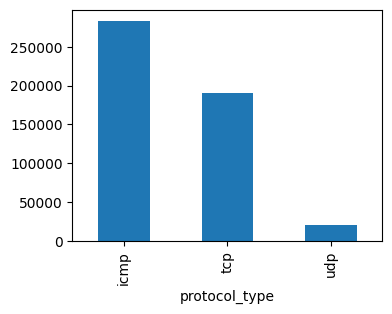

In [11]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'protocol_type')

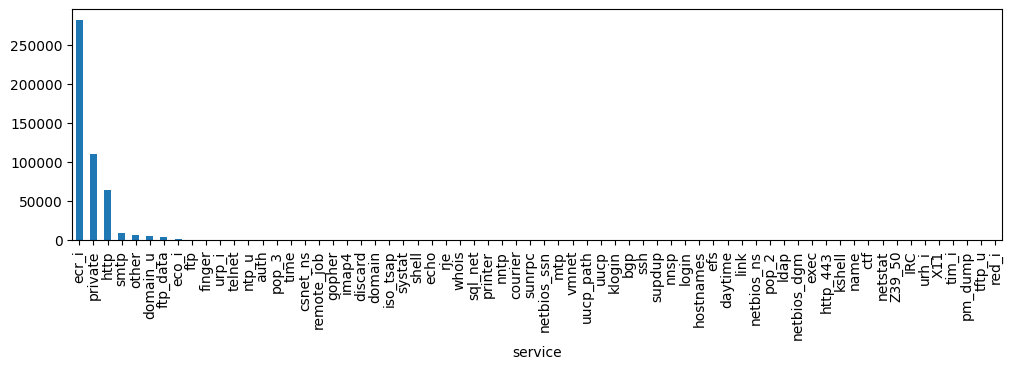

In [12]:
plt.figure(figsize=(12,3))
bar_graph(kdd_df, 'service')

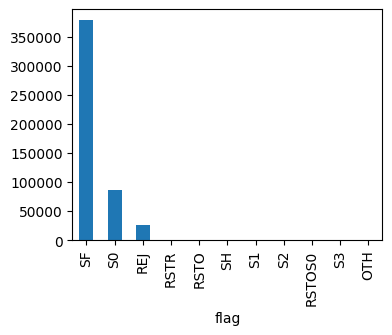

In [13]:
plt.figure(figsize=(4,3))
bar_graph(kdd_df, 'flag')

In [14]:
# protocol_type feature mapping
pmap = {'icmp': 0, 'tcp': 1, 'udp': 2}
kdd_df['protocol_type'] = kdd_df['protocol_type'].map(pmap)

In [15]:
# flag mapping
fmap = {'SF': 0, 'S0': 1, 'REJ':2, 'RSTR': 3, 'RSTO': 4, 'SH': 5 ,'S1': 6 , 'S2': 7, 'RSTOS0': 8, 'S3': 9 , 'OTH': 10}
kdd_df['flag'] = kdd_df['flag'].map(fmap)

In [16]:
kdd_nodrop = kdd_df

remove redundant data (high correlation) to simplify the model without losing significant information.

high correlation (in this context) means that two columns are very similar in terms of their data values.

In [17]:
high_corr_threshold = 0.97

filtered_cols = [col for col in num_cols if col not in ['service', 'protocol_type', 'flag']]

corr_matrix = kdd_df[filtered_cols].corr()
high_corr_pairs = []

for col in corr_matrix.columns:
    related_cols = corr_matrix[col][abs(corr_matrix[col]) > high_corr_threshold].index.tolist()
    if len(related_cols) > 1:
        high_corr_pairs.append((col, related_cols))

keep_columns = set()
drop_columns = set()

grouped_columns = {}
for col, related_cols in high_corr_pairs:
    group = set([col] + related_cols)
    group_key = frozenset(group) # Avoid duplicates by using a frozenset
    if group_key not in grouped_columns:
        grouped_columns[group_key] = list(group)

for group_key, columns in grouped_columns.items():
    columns.sort()
    representative = columns[0]  # Choose the first column as representative
    keep_columns.add(representative)
    for col in columns[1:]:
        drop_columns.add(col)

group_number = 1
for group_key, columns in grouped_columns.items():
    representative = columns[0]
    print(f"Group {group_number} ({representative}-related):")
    print(f"Columns: {', '.join(columns)}")
    print(f"Drop: {', '.join(columns[1:])}")
    print(f"Keep: {representative} (as a representative)\n")
    group_number += 1


Group 1 (num_compromised-related):
Columns: num_compromised, num_root
Drop: num_root
Keep: num_compromised (as a representative)

Group 2 (dst_host_serror_rate-related):
Columns: dst_host_serror_rate, dst_host_srv_serror_rate, serror_rate, srv_serror_rate
Drop: dst_host_srv_serror_rate, serror_rate, srv_serror_rate
Keep: dst_host_serror_rate (as a representative)

Group 3 (dst_host_rerror_rate-related):
Columns: dst_host_rerror_rate, dst_host_srv_rerror_rate, rerror_rate, srv_rerror_rate
Drop: dst_host_srv_rerror_rate, rerror_rate, srv_rerror_rate
Keep: dst_host_rerror_rate (as a representative)

Group 4 (dst_host_same_srv_rate-related):
Columns: dst_host_same_srv_rate, dst_host_srv_count
Drop: dst_host_srv_count
Keep: dst_host_same_srv_rate (as a representative)



In [18]:
kdd_df.shape

(494020, 43)

In [19]:
kdd_df.drop(['num_root'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_rerror_rate', 'rerror_rate', 'srv_rerror_rate'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_count'],axis = 1,inplace = True)

In [20]:
kdd_df.shape

(494020, 35)

In [21]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,target,attack_type
0,0,1,http,0,239,486,0,0,0,0,...,0.0,19,1.0,0.0,0.05,0.0,0.0,0.0,normal.,normal
1,0,1,http,0,235,1337,0,0,0,0,...,0.0,29,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
2,0,1,http,0,219,1337,0,0,0,0,...,0.0,39,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
3,0,1,http,0,217,2032,0,0,0,0,...,0.0,49,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal
4,0,1,http,0,217,2032,0,0,0,0,...,0.0,59,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal


drop target out as we aim to classify the types of atttack

In [22]:
kdd_df['target'].value_counts()

,count
target,
smurf.,280790
neptune.,107201
normal.,97277
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979


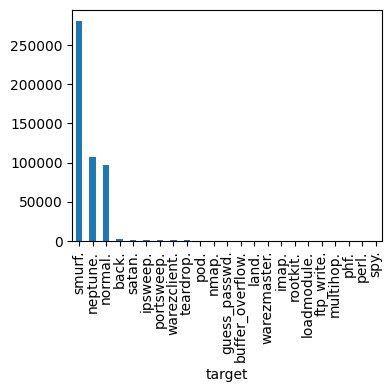

In [23]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'target')

In [24]:
kdd_df['attack_type'].value_counts()

,count
attack_type,
dos,391458
normal,97277
probe,4107
r2l,1126
u2r,52


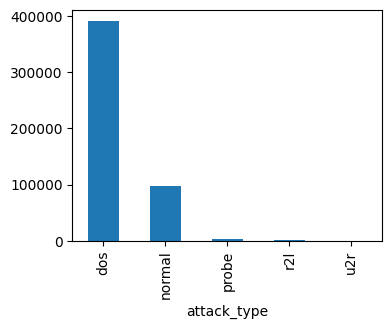

In [25]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'attack_type')

In [26]:
kdd_df['service'].value_counts()

,count
service,
ecr_i,281400
private,110893
http,64292
smtp,9723
other,7237
...,...
X11,11
tim_i,7
pm_dump,1


In [27]:
kdd_df.drop('service', axis = 1, inplace= True)

In [28]:
kdd_df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,srv_diff_host_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,target,attack_type
0,0,1,0,239,486,0,0,0,0,0,...,0.0,19,1.0,0.0,0.05,0.0,0.0,0.0,normal.,normal
1,0,1,0,235,1337,0,0,0,0,0,...,0.0,29,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
2,0,1,0,219,1337,0,0,0,0,0,...,0.0,39,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
3,0,1,0,217,2032,0,0,0,0,0,...,0.0,49,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal
4,0,1,0,217,2032,0,0,0,0,0,...,0.0,59,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal


In [29]:
len(kdd_df.columns)

34

# Scaling

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [31]:
kdd_df = kdd_df.drop(['target'], axis=1)

In [32]:
kdd_nodrop = kdd_nodrop.drop(['target'], axis=1)

In [33]:
X = kdd_df.drop(['attack_type',], axis=1)
Y = kdd_df[['attack_type']]

In [34]:
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)

In [35]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_scaled, Y, test_size=0.30, random_state=1166)

In [36]:
print(X_train_scaled.shape, X_test_scaled.shape)
print(Y_train_scaled.shape, Y_test_scaled.shape)

(345814, 32) (148206, 32)
(345814, 1) (148206, 1)


# GaussainNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
#TRAINING
model_gnb = GaussianNB()
start_time_gnb = time.time()
model_gnb.fit(X_train_scaled, Y_train_scaled.values.ravel())
end_time_gnb = time.time()
print("Training time: ", end_time_gnb - start_time_gnb)

Training time:  0.9259908199310303


In [ ]:
# TESTING
start_time_gnb = time.time()
Y_pred_gnb = model_gnb.predict(X_test_scaled)
end_time_gnb = time.time()
print("Testing time: ", end_time_gnb - start_time_gnb)

Testing time:  0.22665667533874512


In [ ]:
print("Train score is:", model_gnb.score(X_train_scaled, Y_train_scaled))
print("Test score is:", model_gnb.score(X_test_scaled, Y_test_scaled))

Train score is: 0.8373692216046776
Test score is: 0.8371253525498293


In [ ]:
print("Accuracy:", accuracy_score(Y_test_scaled, Y_pred_gnb))

Accuracy: 0.8371253525498293


In [ ]:
print("\nClassification Report:\n", classification_report(Y_test_scaled, Y_pred_gnb))


Classification Report:
               precision    recall  f1-score   support

         dos       0.98      0.94      0.96    117411
      normal       0.99      0.42      0.59     29193
       probe       0.09      0.99      0.16      1243
         r2l       0.06      0.40      0.10       338
         u2r       0.00      0.81      0.00        21

    accuracy                           0.84    148206
   macro avg       0.42      0.71      0.36    148206
weighted avg       0.97      0.84      0.88    148206



In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=4014)

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    model_gnb = GaussianNB()
    model_gnb.fit(X_train_fold, Y_train_fold.values.ravel())

    Y_pred_fold = model_gnb.predict(X_test_fold)

    accuracy = accuracy_score(Y_test_fold, Y_pred_fold)
    print(f"Fold accuracy: {accuracy}")
    # print(f"Classification Report:\n", classification_report(Y_test_fold, Y_pred_fold))

Fold accuracy: 0.8560382170762317
Fold accuracy: 0.8525363345613538
Fold accuracy: 0.8593882838751468
Fold accuracy: 0.8486498522327032
Fold accuracy: 0.8508056353993766


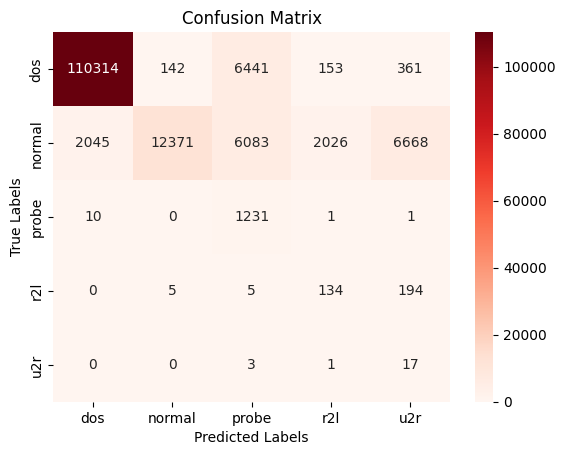

In [ ]:
cm_gnb = confusion_matrix(Y_test_scaled, Y_pred_gnb)

labels = ["dos", "normal", "probe", "r2l", "u2r"]

sns.heatmap(cm_gnb, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
# TRAINING
model = LogisticRegression(max_iter=1200000, random_state=42)
start_time = time.time()
model.fit(X_train_scaled, Y_train_scaled.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

Training time:  14.617627143859863


In [ ]:
# TESTING
start_time = time.time()
Y_pred = model.predict(X_test_scaled)
end_time = time.time()
print("Testing time: ",end_time-start_time)

Testing time:  0.025295734405517578


In [ ]:
print("Train score is:", model.score(X_train_scaled, Y_train_scaled))
print("Test score is:",model.score(X_test_scaled,Y_test_scaled))

Train score is: 0.9955120382633439
Test score is: 0.9954387811559586


In [ ]:
print("Accuracy:", accuracy_score(Y_test_scaled, Y_pred))

Accuracy: 0.9954387811559586


In [ ]:
print("\nClassification Report:\n", classification_report(Y_test_scaled, Y_pred))


Classification Report:
               precision    recall  f1-score   support

         dos       1.00      1.00      1.00    117411
      normal       0.98      1.00      0.99     29193
       probe       0.98      0.88      0.93      1243
         r2l       0.85      0.43      0.58       338
         u2r       0.80      0.19      0.31        21

    accuracy                           1.00    148206
   macro avg       0.92      0.70      0.76    148206
weighted avg       1.00      1.00      1.00    148206



In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=4014)

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    model_logis = LogisticRegression()
    model_logis.fit(X_train_fold, Y_train_fold.values.ravel())

    Y_pred_fold = model_logis.predict(X_test_fold)

    accuracy = accuracy_score(Y_test_fold, Y_pred_fold)
    print(f"Fold accuracy: {accuracy}")
    # print(f"Classification Report:\n", classification_report(Y_test_fold, Y_pred_fold))

Fold accuracy: 0.9935427715477106
Fold accuracy: 0.9947269341322214
Fold accuracy: 0.9942613659366017
Fold accuracy: 0.9947674183231449
Fold accuracy: 0.9958908546212704


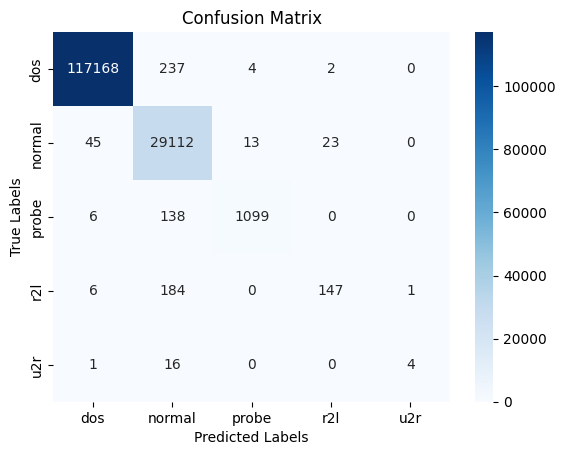

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test_scaled, Y_pred)

labels = ["dos", "normal", "probe", "r2l", "u2r"]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# KerasClassifier

In [1]:
%%capture
# !pip install keras==2.12.0
# !pip install scikeras=0.11.0

!pip install --upgrade keras
!pip install --upgrade scikeras

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [38]:
from sklearn.preprocessing import LabelBinarizer

In [39]:
encoder = LabelBinarizer()
Y_train_encoded = encoder.fit_transform(Y_train_scaled)
Y_test_encoded = encoder.transform(Y_test_scaled)

In [40]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_shape=(X_train_scaled.shape[1],),activation = 'relu',kernel_initializer='random_uniform'))
    model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
    model.add(Dense(5,activation='softmax'))
    model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

    return model

In [41]:
# keras_model = KerasClassifier(build_fn=create_model,epochs=25,batch_size=64)

In [46]:
param_grid = {
    'epochs': [10, 20],
    # 'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'sgd']
}

keras_network = KerasClassifier(model=create_model, verbose=1, batch_size=64)
grid = GridSearchCV(estimator=keras_network, param_grid=param_grid, n_jobs=1)
grid_start = time.time()
grid_result = grid.fit(X_train_scaled, Y_train_encoded)
grid_end = time.time()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8873 - loss: 0.5931
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9843 - loss: 0.0941
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0702
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0659
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9842 - loss: 0.0634
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0603
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0577
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0570
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9849 - loss: 0.0546
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0538
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8852 - loss: 0.7825
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9841 - loss: 0.1111
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9849 - loss: 0.0795
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9850 - loss: 0.0682
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0652
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9850 - loss: 0.0634
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0637
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0625
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9848 - loss: 0.0613
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0613
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6953 - loss: 0.7877
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: 0.1247
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0743
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9849 - loss: 0.0666
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9845 - loss: 0.0659
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9842 - loss: 0.0636
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0603
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0587
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9843 - loss: 0.0586
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9852 - loss: 0.0550
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8398 - loss: 0.8625
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.1087
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9848 - loss: 0.0750
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9844 - loss: 0.0709
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0676
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0665
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0648
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0646
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9846 - loss: 0.0645
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9849 - loss: 0.0626
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8618 - loss: 0.8337
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9844 - loss: 0.1044
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: 0.0765
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9845 - loss: 0.0699
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0672
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9845 - loss: 0.0673
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9845 - loss: 0.0651
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0637
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0633
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0628
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8494 - loss: 0.8508
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: 0.1069
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9844 - loss: 0.0760
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0698
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9850 - loss: 0.0665
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0662
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9851 - loss: 0.0640
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9842 - loss: 0.0667
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0643
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9844 - loss: 0.0648
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8899 - loss: 0.8023
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.1085
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0754
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9844 - loss: 0.0699
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9852 - loss: 0.0647
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0650
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9846 - loss: 0.0640
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0632
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0633
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9848 - loss: 0.0624
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8187 - loss: 0.6340
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9840 - loss: 0.1034
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0740
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0714
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0705
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0705
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0669
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0647
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0649
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9845 - loss: 0.0604
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8093 - loss: 0.6520
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9845 - loss: 0.0995
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0731
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0699
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9840 - loss: 0.0689
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9849 - loss: 0.0628
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0608
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0582
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0571
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0549
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7689 - loss: 0.6921
Epoch 2/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9841 - loss: 0.1076
Epoch 3/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0741
Epoch 4/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0700
Epoch 5/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0665
Epoch 6/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0624
Epoch 7/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0597
Epoch 8/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9851 - loss: 0.0568
Epoch 9/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0571
Epoch 10/10
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0559
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9237 - loss: 0.4086
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9842 - loss: 0.0865
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0690
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0644
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0614
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0599
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9845 - loss: 0.0575
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0546
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9849 - loss: 0.0537
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9843 - loss: 0.0504
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9851 - loss: 0.0412
Epoch 12/20
4323/4323 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9170 - loss: 0.4799
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0885
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9843 - loss: 0.0729
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9843 - loss: 0.0680
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0622
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9844 - loss: 0.0609
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9849 - loss: 0.0575
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9844 - loss: 0.0568
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9843 - loss: 0.0569
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0551
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0536
Epoch 12/20
4323/4323 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7801 - loss: 0.7605
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9844 - loss: 0.0957
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0701
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9844 - loss: 0.0648
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0612
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0594
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0576
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0561
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9882 - loss: 0.0342
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9917 - loss: 0.0276
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9954 - loss: 0.0218
Epoch 12/20
4323/4323 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7436 - loss: 0.7207
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9842 - loss: 0.1064
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9851 - loss: 0.0728
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9846 - loss: 0.0691
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0625
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9851 - loss: 0.0599
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9852 - loss: 0.0568
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0569
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9844 - loss: 0.0565
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0554
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0544
Epoch 12/20
4323/4323 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8563 - loss: 0.8476
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9845 - loss: 0.1075
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9845 - loss: 0.0747
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9841 - loss: 0.0711
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9850 - loss: 0.0659
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0662
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9848 - loss: 0.0649
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0640
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0642
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9850 - loss: 0.0623
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9848 - loss: 0.0622
Epoch 12/20
4323/4323 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8086 - loss: 0.7140
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9843 - loss: 0.0999
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9846 - loss: 0.0744
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0715
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9847 - loss: 0.0708
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: 0.0723
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0698
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9848 - loss: 0.0652
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0632
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9846 - loss: 0.0606
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9841 - loss: 0.0607
Epoch 12/20
4323/4323 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7642 - loss: 0.6532
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9845 - loss: 0.1006
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9844 - loss: 0.0748
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9847 - loss: 0.0700
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0681
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0657
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9840 - loss: 0.0638
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0600
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9843 - loss: 0.0605
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0577
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0581
Epoch 12/20
4323/4323 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8076 - loss: 0.6203
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9844 - loss: 0.0948
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: 0.0714
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9844 - loss: 0.0647
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9844 - loss: 0.0612
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9845 - loss: 0.0599
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9843 - loss: 0.0587
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9845 - loss: 0.0566
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9842 - loss: 0.0538
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9873 - loss: 0.0370
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9904 - loss: 0.0277
Epoch 12/20
4323/4323 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8705 - loss: 0.8330
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.1118
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0748
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0693
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0668
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9851 - loss: 0.0647
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0653
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0647
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9852 - loss: 0.0616
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9850 - loss: 0.0625
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9848 - loss: 0.0622
Epoch 12/20
4323/4323 ━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8312 - loss: 0.8626
Epoch 2/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9846 - loss: 0.1116
Epoch 3/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9847 - loss: 0.0797
Epoch 4/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9844 - loss: 0.0703
Epoch 5/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9847 - loss: 0.0676
Epoch 6/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9846 - loss: 0.0661
Epoch 7/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0644
Epoch 8/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9849 - loss: 0.0633
Epoch 9/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9850 - loss: 0.0614
Epoch 10/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9848 - loss: 0.0606
Epoch 11/20
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9842 - loss: 0.0545
Epoch 12/20
4323/4323 ━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5404/5404 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7773 - loss: 0.8785
Epoch 2/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9847 - loss: 0.0946
Epoch 3/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9844 - loss: 0.0728
Epoch 4/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: 0.0696
Epoch 5/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9845 - loss: 0.0674
Epoch 6/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9843 - loss: 0.0669
Epoch 7/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9850 - loss: 0.0631
Epoch 8/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9849 - loss: 0.0595
Epoch 9/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9852 - loss: 0.0517
Epoch 10/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9887 - loss: 0.0383
Epoch 11/20
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9889 - loss: 0.0299
Epoch 12/20
5404/5404 ━━━━━━━━

In [ ]:
# start = time.time()
# keras_model.fit(X_train_scaled, Y_train_encoded)
# end = time.time()

In [47]:
print("Training time for KerasClassifier with GridSearchCV:", grid_end - grid_start)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Training time for KerasClassifier with GridSearchCV: 3210.4963612556458
Best: 0.992866 using {'epochs': 20, 'optimizer': 'sgd'}
0.984691 (0.000309) with: {'epochs': 10, 'optimizer': 'adam'}
0.984654 (0.000400) with: {'epochs': 10, 'optimizer': 'sgd'}
0.992158 (0.005358) with: {'epochs': 20, 'optimizer': 'adam'}
0.992866 (0.004675) with: {'epochs': 20, 'optimizer': 'sgd'}


2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy for KerasClassifier: 0.9965588437715073


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for KerasClassifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    117411
           1       1.00      1.00      1.00     29193
           2       0.77      0.96      0.85      1243
           3       0.00      0.00      0.00       338
           4       0.00      0.00      0.00        21

   micro avg       1.00      1.00      1.00    148206
   macro avg       0.55      0.59      0.57    148206
weighted avg       0.99      1.00      1.00    148206
 samples avg       1.00      1.00      1.00    148206



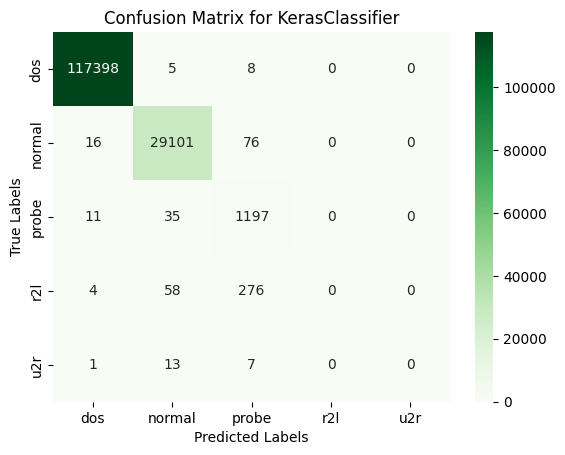

In [51]:
Y_pred_keras = grid_result.best_estimator_.predict(X_test_scaled)
print("Accuracy for KerasClassifier:", accuracy_score(Y_test_encoded, Y_pred_keras))
print("\nClassification Report for KerasClassifier:\n", classification_report(Y_test_encoded, Y_pred_keras))

cm_keras = confusion_matrix(Y_test_encoded.argmax(axis=1), Y_pred_keras.argmax(axis=1))

labels = ["dos", "normal", "probe", "r2l", "u2r"]

sns.heatmap(cm_keras, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for KerasClassifier")
plt.show()

# GAN

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers
import time

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_enc = LabelEncoder()

In [ ]:
kdd_nodrop['attack_type'] = label_enc.fit_transform(kdd_nodrop['attack_type'])

In [ ]:
gan = kdd_nodrop[kdd_nodrop['attack_type'] == 0][:50000]

In [ ]:
gan_x = gan.drop(['attack_type',], axis=1)
gan_y = gan[['attack_type']]

In [ ]:
gan_x.shape

(50000, 32)

In [ ]:
gan_y.shape

(50000, 1)

In [ ]:
gan_x_train, gan_x_test, gan_y_train, gan_y_test = train_test_split(gan_x, gan_y, test_size=0.30, random_state=1166)

In [ ]:
gan_x_train.shape

(35000, 32)

In [ ]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(100,)),  # Input shape for noise
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='tanh')  # Output layer for 32 features
    ])
    return model

noise_dim = 100  # Dimension of the noise vector
generator = build_generator(noise_dim)

# Test the generator
# Generate a random noise vector
test_noise = tf.random.normal([1, noise_dim])
generated_data = generator(test_noise)
print(generated_data.shape)

(1, 32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(32,)),  # Adjust input shape if needed
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
cross_entropy = BinaryCrossentropy(from_logits=True)



def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output) # Wasserstein loss

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-5) #Adjusted learning rate to improve the model
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [ ]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # Create noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
history = {'gen': [], 'dis': []}

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            gen_loss, dis_loss = train_step(batch)

        history['gen'].append(gen_loss)
        history['dis'].append(dis_loss)
        print('Time for epoch {} is {} sec '.format(epoch + 1, time.time() - start))

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_normalized = scaler.fit_transform(gan_x_train)  # Normalize all features
test_df_normalized = scaler.fit_transform(gan_x_test)  # Normalize all features

# Convert to a TensorFlow tensor
import tensorflow as tf

df_normalized_tensor = tf.convert_to_tensor(df_normalized, dtype=tf.float32)
test_df_normalized_tensor = tf.convert_to_tensor(test_df_normalized, dtype=tf.float32)

In [ ]:
def create_tf_dataset(data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size=len(data))  # Shuffle the dataset
    dataset = dataset.batch(batch_size)  # Create batches
    return dataset

BATCH_SIZE = 64 # try 64 now
tf_dataset = create_tf_dataset(df_normalized_tensor, BATCH_SIZE)

In [ ]:
EPOCHS = 150  # Set the number of epochs
train(tf_dataset, EPOCHS)

Time for epoch 1 is 6.902750730514526 sec 
Time for epoch 2 is 3.25211501121521 sec 
Time for epoch 3 is 3.9055497646331787 sec 
Time for epoch 4 is 3.077702283859253 sec 
Time for epoch 5 is 3.0960965156555176 sec 
Time for epoch 6 is 3.2679121494293213 sec 
Time for epoch 7 is 4.3216469287872314 sec 
Time for epoch 8 is 3.5415027141571045 sec 
Time for epoch 9 is 3.035123348236084 sec 
Time for epoch 10 is 3.825789451599121 sec 
Time for epoch 11 is 3.251466751098633 sec 
Time for epoch 12 is 3.0338351726531982 sec 
Time for epoch 13 is 3.041971206665039 sec 
Time for epoch 14 is 3.8413050174713135 sec 
Time for epoch 15 is 3.2268002033233643 sec 
Time for epoch 16 is 3.0842535495758057 sec 
Time for epoch 17 is 3.062533378601074 sec 
Time for epoch 18 is 3.916836738586426 sec 
Time for epoch 19 is 3.10072922706604 sec 
Time for epoch 20 is 3.0626492500305176 sec 
Time for epoch 21 is 3.0274927616119385 sec 
Time for epoch 22 is 4.033343315124512 sec 
Time for epoch 23 is 3.050975322

In [ ]:
y_pred = discriminator.predict(test_df_normalized_tensor)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_pred

array([[ 0.38446236],
       [-1.7026048 ],
       [ 0.2099002 ],
       ...,
       [-0.01348332],
       [ 0.02675891],
       [ 0.19444323]], dtype=float32)

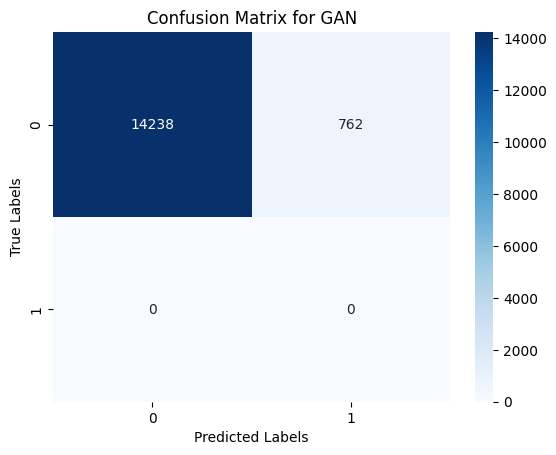

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_pred contains predicted probabilities
# Convert probabilities to class labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)


cm = confusion_matrix(gan_y_test, y_pred_labels)

labels = ["0", "1"]  # Assuming binary classification

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for GAN")
plt.show()

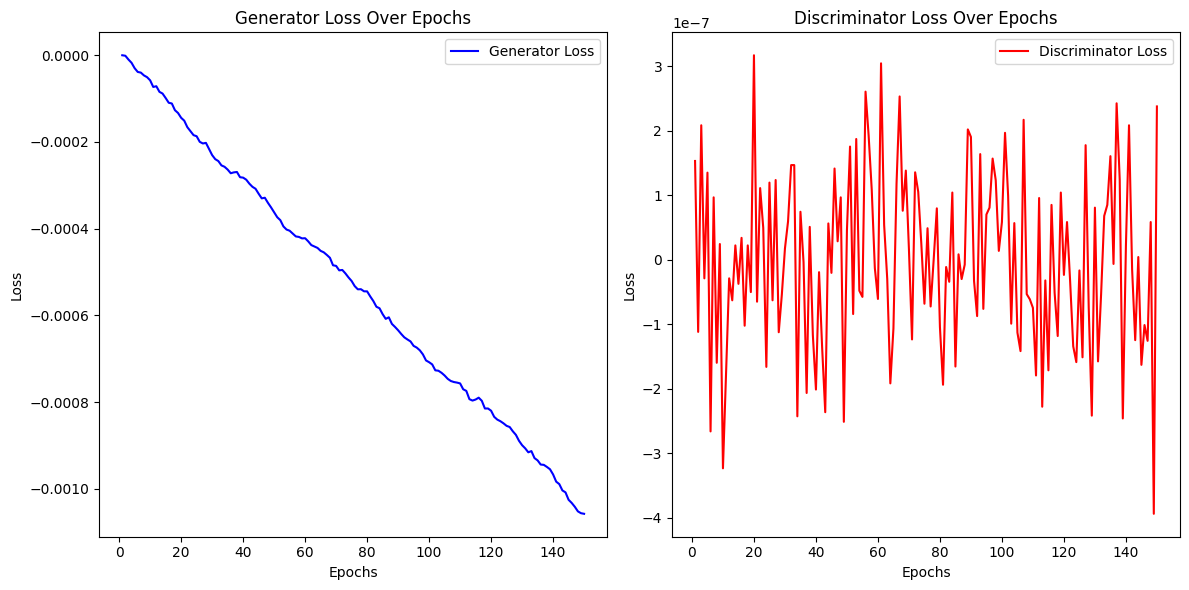

In [ ]:
epochs = range(1, len(history['gen']) + 1)

plt.figure(figsize=(12, 6))

# Plot Generator Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['gen'], label='Generator Loss', color='blue')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history['dis'], label='Discriminator Loss', color='red')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score, accuracy_score ,recall_score, f1_score
prob=[0.2,0.4,0.6,0.8,1.0]
for p in prob:
    pred_value =[1 if i<p  else 0 for i in y_pred]
    f1=f1_score(gan_y_test,pred_value)
    acc=accuracy_score(gan_y_test,pred_value)
    precision=average_precision_score(gan_y_test,pred_value)
    recall= recall_score(gan_y_test,pred_value)
    print(f'prob ={p} and f1 score ={f1} : accuracy={acc} : precision={precision} : recall={recall}')
    print(pred_value.count(0),pred_value.count(1))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-package

prob =0.2 and f1 score =0.0 : accuracy=0.6935333333333333 : precision=-0.0 : recall=0.0
10403 4597
prob =0.4 and f1 score =0.0 : accuracy=0.5621333333333334 : precision=-0.0 : recall=0.0
8432 6568
prob =0.6 and f1 score =0.0 : accuracy=0.007533333333333334 : precision=-0.0 : recall=0.0
113 14887
prob =0.8 and f1 score =0.0 : accuracy=0.0012666666666666666 : precision=-0.0 : recall=0.0
19 14981
prob =1.0 and f1 score =0.0 : accuracy=0.0010666666666666667 : precision=-0.0 : recall=0.0
16 14984


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
